In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Layer
import time
from matplotlib import pyplot as plt

In [2]:
class FBSNN(): # Forward-Backward Stochastic Neural Network
    def __init__(self, layers, Xi, T,
                       M, N, D):
        '''
        layers: list of number of neurons in each layer
        layers[1] is the input layer
        layers[-1] is the output layer normally 1
        '''
        # initial point
        self.Xi = Xi
        # terminal time
        self.T = T
        # number of trajectories
        self.M = M
        # number of time snapshots
        self.N = N
        # number of dimensions
        self.D = D

        # layers eg [100, 256, 256, 256, 256, 1]
        layers[0] = D+1
        self.layers = layers
        model = tf.keras.Sequential()
        for layer in layers[:-1]:
            model.add(Dense(layer, activation=None, kernel_initializer='glorot_normal', bias_initializer='zeros'))
            model.add(SinActivation())
        model.add(Dense(layers[-1]))
        self.model = model

    def call(self, inputs):
        return self.model(inputs)

    def optimizer(self, learning_rate):
        # return tf.keras.optimizers.legacy.Adam(learning_rate)
        return tf.keras.optimizers.Adam(learning_rate)

    def net_u(self, t, X): # M x 1, M x D
        with tf.GradientTape() as tape:
            tape.watch(X)
            u = self.model(tf.concat([t,X],1)) # M x 1
            Du = tape.gradient(u, X)[0] # M x D
        return u, Du

    def Dg_tf(self, X): # M x D
        with tf.GradientTape() as tape:
            tape.watch(X)
            return tape.gradient(self.g_tf(X), X)[0]

    def fetch_minibatch(self):
        T = self.T

        M = self.M
        N = self.N
        D = self.D

        Dt = np.zeros((M,N+1,1)) # M x (N+1) x 1
        DW = np.zeros((M,N+1,D)) # M x (N+1) x D

        dt = T/N

        Dt[:,1:,:] = dt
        DW[:,1:,:] = np.sqrt(dt)*np.random.normal(size=(M,N,D))

        t = np.cumsum(Dt,axis=1) # M x (N+1) x 1
        W = np.cumsum(DW,axis=1) # M x (N+1) x D
        t = tf.convert_to_tensor(t, dtype=tf.float32)
        W = tf.convert_to_tensor(W, dtype=tf.float32)

        return t, W

    def loss_function(self, t, W, Xi):
        loss = 0
        X_list = []
        Y_list = []

        t0 = t[:,0,:]
        W0 = W[:,0,:]
        X0 = tf.tile(Xi,[self.M,1]) # M x D
        Y0, Z0 = self.net_u(t0,X0) # M x 1, M x D

        X_list.append(X0)
        Y_list.append(Y0)

        for n in range(0,self.N):
            t1 = t[:,n+1,:]
            W1 = W[:,n+1,:]
            X1 = X0 + self.mu_tf(t0,X0,Y0,Z0)*(t1-t0) + tf.squeeze(tf.matmul(self.sigma_tf(t0,X0,Y0),tf.expand_dims(W1-W0,-1)), axis=[-1])
            Y1_tilde = Y0 + self.phi_tf(t0,X0,Y0,Z0)*(t1-t0) + tf.reduce_sum(Z0*tf.squeeze(tf.matmul(self.sigma_tf(t0,X0,Y0),tf.expand_dims(W1-W0,-1))), axis=1, keepdims = True)
            Y1, Z1 = self.net_u(t1,X1)

            loss += tf.reduce_sum(tf.square(Y1 - Y1_tilde))

            t0 = t1
            W0 = W1
            X0 = X1
            Y0 = Y1
            Z0 = Z1

            X_list.append(X0)
            Y_list.append(Y0)

        loss += tf.reduce_sum(tf.square(Y1 - self.g_tf(X1)))
        loss += tf.reduce_sum(tf.square(Z1 - self.Dg_tf(X1)))
        X = tf.stack(X_list,axis=1)
        Y = tf.stack(Y_list,axis=1)

        return loss, X, Y, Y[0,0,0]

    def train(self, N_Iter, learning_rate):
        optimizer = self.optimizer(learning_rate)
        start_time = time.time()
        loss_list = []
        for it in range(N_Iter):
            t_batch, W_batch = self.fetch_minibatch() # M x (N+1) x 1, M x (N+1) x D
            with tf.GradientTape() as tape:
                loss, X, Y, Y0 = self.loss_function(t_batch, W_batch, self.Xi)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            elapsed = time.time() - start_time
            print(f'Epoch {it+1}/{N_Iter}, Loss: {loss.numpy()}, Time: {elapsed}')
            loss_list.append(loss.numpy())
            start_time = time.time()
        plt.plot(loss_list)
        plt.show()

    def predict(self, Xi_star, t_star, W_star):
        X_star = Xi_star + W_star
        Y_star = self.model(tf.concat([t_star, X_star], 2))
        return X_star.numpy(), Y_star.numpy()

    def phi_tf(self, t, X, Y, Z): # M x 1, M x D, M x 1, M x D
        return 0.05*(Y - tf.reduce_sum(X*Z, 1, keepdims = True)) # M x 1

    def g_tf(self, X):
        return tf.reduce_sum(X**2, 1, keepdims = True) # M x 1

    def mu_tf(self, t, X, Y, Z): # M x 1, M x D, M x 1, M x D
        M = self.M
        D = self.D
        return np.zeros([M,D]) # M x D

    def sigma_tf(self, t, X, Y): # M x 1, M x D, M x 1
        return 0.4*tf.linalg.diag(X) # M x D x D



class SinActivation(Layer):
    def __init__(self):
        super(SinActivation, self).__init__()

    def call(self, inputs):
        return tf.math.sin(inputs)

Epoch 1/1000, Loss: 535868.8125, Time: 0.7665648460388184
Epoch 2/1000, Loss: 469525.8125, Time: 0.7959561347961426
Epoch 3/1000, Loss: 406462.03125, Time: 0.7117941379547119
Epoch 4/1000, Loss: 373256.78125, Time: 0.6682050228118896
Epoch 5/1000, Loss: 359749.03125, Time: 0.6581070423126221
Epoch 6/1000, Loss: 350865.28125, Time: 0.666496992111206
Epoch 7/1000, Loss: 328320.84375, Time: 0.701024055480957
Epoch 8/1000, Loss: 312961.0625, Time: 0.678840160369873
Epoch 9/1000, Loss: 297219.71875, Time: 0.6522057056427002
Epoch 10/1000, Loss: 294078.34375, Time: 0.6487851142883301
Epoch 11/1000, Loss: 287938.09375, Time: 0.6505589485168457
Epoch 12/1000, Loss: 291316.875, Time: 0.6548788547515869
Epoch 13/1000, Loss: 277641.15625, Time: 0.6613481044769287
Epoch 14/1000, Loss: 274956.1875, Time: 0.6617960929870605
Epoch 15/1000, Loss: 281555.65625, Time: 0.653278112411499
Epoch 16/1000, Loss: 274387.625, Time: 0.6497752666473389
Epoch 17/1000, Loss: 265570.9375, Time: 0.6415848731994629
Ep

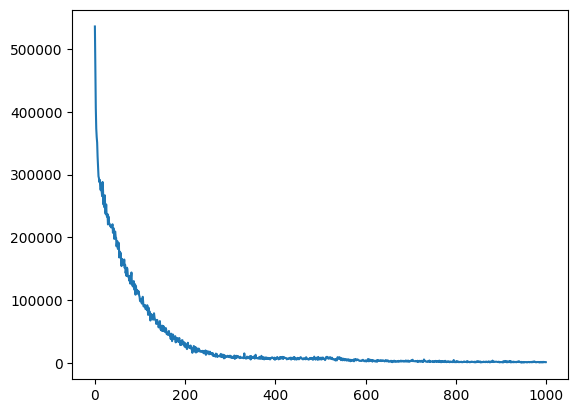

Epoch 1/1000, Loss: 1121.3721923828125, Time: 0.742603063583374
Epoch 2/1000, Loss: 1460.7633056640625, Time: 0.7128818035125732
Epoch 3/1000, Loss: 927.3046264648438, Time: 0.7387170791625977
Epoch 4/1000, Loss: 1045.23388671875, Time: 0.7002849578857422
Epoch 5/1000, Loss: 1071.2852783203125, Time: 0.7024357318878174
Epoch 6/1000, Loss: 1102.460205078125, Time: 0.6940751075744629
Epoch 7/1000, Loss: 807.6707153320312, Time: 0.7199499607086182
Epoch 8/1000, Loss: 852.5829467773438, Time: 0.7205278873443604
Epoch 9/1000, Loss: 1732.732666015625, Time: 0.7165210247039795
Epoch 10/1000, Loss: 809.8880615234375, Time: 0.7480790615081787
Epoch 11/1000, Loss: 870.5816650390625, Time: 0.6916098594665527
Epoch 12/1000, Loss: 1613.8060302734375, Time: 0.7055580615997314
Epoch 13/1000, Loss: 1511.890869140625, Time: 0.7076292037963867
Epoch 14/1000, Loss: 1071.4476318359375, Time: 0.6909544467926025
Epoch 15/1000, Loss: 943.8617553710938, Time: 0.720444917678833
Epoch 16/1000, Loss: 712.8933105

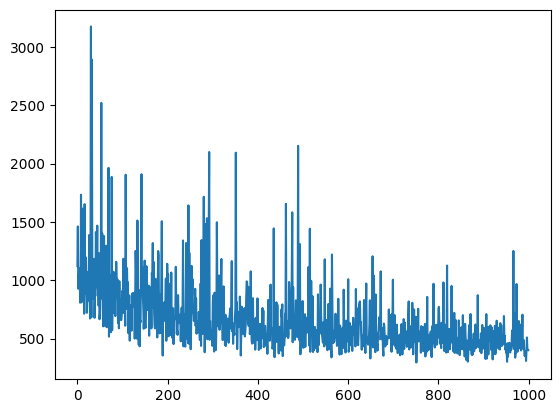

Epoch 1/1000, Loss: 752.3644409179688, Time: 0.7575497627258301
Epoch 2/1000, Loss: 402.9452819824219, Time: 0.7740252017974854
Epoch 3/1000, Loss: 407.9050598144531, Time: 0.7465391159057617
Epoch 4/1000, Loss: 727.9656982421875, Time: 0.7045891284942627
Epoch 5/1000, Loss: 466.797607421875, Time: 0.6813886165618896
Epoch 6/1000, Loss: 352.4083251953125, Time: 0.6790447235107422
Epoch 7/1000, Loss: 403.51409912109375, Time: 0.7029004096984863
Epoch 8/1000, Loss: 511.4598693847656, Time: 0.7000250816345215
Epoch 9/1000, Loss: 513.1172485351562, Time: 0.7041699886322021
Epoch 10/1000, Loss: 405.2854309082031, Time: 0.6828351020812988
Epoch 11/1000, Loss: 501.4280090332031, Time: 0.6921279430389404
Epoch 12/1000, Loss: 432.8941650390625, Time: 0.6859681606292725
Epoch 13/1000, Loss: 672.0714721679688, Time: 0.6765599250793457
Epoch 14/1000, Loss: 980.4954833984375, Time: 0.7134048938751221
Epoch 15/1000, Loss: 428.3887939453125, Time: 0.6813888549804688
Epoch 16/1000, Loss: 806.960083007

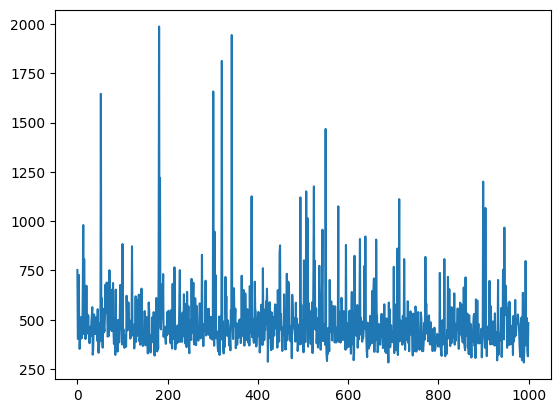

Epoch 1/1000, Loss: 622.2794189453125, Time: 0.8158149719238281
Epoch 2/1000, Loss: 435.83465576171875, Time: 0.761742115020752
Epoch 3/1000, Loss: 357.2906494140625, Time: 0.7418928146362305
Epoch 4/1000, Loss: 579.600341796875, Time: 0.708444356918335
Epoch 5/1000, Loss: 483.7261962890625, Time: 0.7104496955871582
Epoch 6/1000, Loss: 1033.3485107421875, Time: 0.7100820541381836
Epoch 7/1000, Loss: 494.6923828125, Time: 0.7139489650726318
Epoch 8/1000, Loss: 425.2438049316406, Time: 0.6992383003234863
Epoch 9/1000, Loss: 513.26171875, Time: 0.7524042129516602
Epoch 10/1000, Loss: 666.10205078125, Time: 0.6827831268310547
Epoch 11/1000, Loss: 348.2355041503906, Time: 0.7776148319244385
Epoch 12/1000, Loss: 902.8937377929688, Time: 0.7328808307647705
Epoch 13/1000, Loss: 378.51123046875, Time: 0.774101972579956
Epoch 14/1000, Loss: 746.1526489257812, Time: 0.7555408477783203
Epoch 15/1000, Loss: 365.6643981933594, Time: 0.6987147331237793
Epoch 16/1000, Loss: 316.8831787109375, Time: 0.

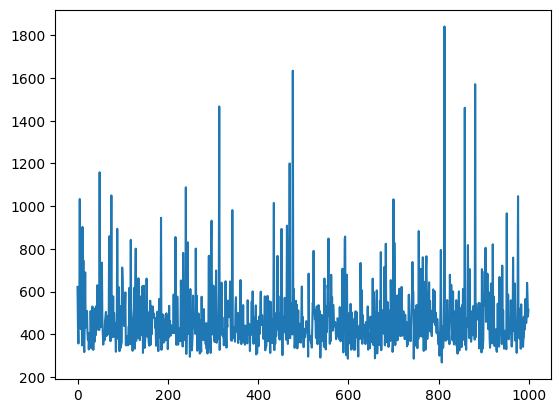

Epoch 1/1000, Loss: 415.55560302734375, Time: 0.7955529689788818
Epoch 2/1000, Loss: 404.2579650878906, Time: 0.678093671798706
Epoch 3/1000, Loss: 339.8123779296875, Time: 0.6865720748901367
Epoch 4/1000, Loss: 418.94561767578125, Time: 0.6796591281890869
Epoch 5/1000, Loss: 347.15533447265625, Time: 0.6867799758911133
Epoch 6/1000, Loss: 865.62744140625, Time: 0.6947200298309326
Epoch 7/1000, Loss: 466.13775634765625, Time: 0.6770429611206055
Epoch 8/1000, Loss: 486.44049072265625, Time: 0.687302827835083
Epoch 9/1000, Loss: 381.6001892089844, Time: 0.6919620037078857
Epoch 10/1000, Loss: 473.7900390625, Time: 0.6984319686889648
Epoch 11/1000, Loss: 366.8134765625, Time: 0.6849918365478516
Epoch 12/1000, Loss: 559.531982421875, Time: 0.6941969394683838
Epoch 13/1000, Loss: 591.400390625, Time: 0.70461106300354
Epoch 14/1000, Loss: 419.4404602050781, Time: 0.7042500972747803
Epoch 15/1000, Loss: 654.17333984375, Time: 0.684838056564331
Epoch 16/1000, Loss: 327.79705810546875, Time: 0.

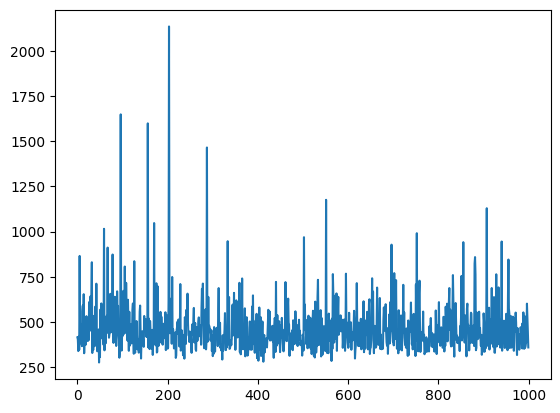

In [3]:
M = 100  # number of trajectories (batch size)
N = 50  # number of time snapshots
D = 100  # number of dimensions
T = 1.0
Xi = np.array([1.0,0.5]*int(D/2))[None,:]
Xi = tf.convert_to_tensor(Xi, dtype=tf.float32)
layers = [D+1] + 4*[256] + [1]

model = FBSNN(layers, Xi, T, M, N, D)
model.train(N_Iter = 1000, learning_rate=1e-3)
model.train(N_Iter = 1000, learning_rate=1e-4)
model.train(N_Iter = 1000, learning_rate=1e-5)
model.train(N_Iter = 1000, learning_rate=1e-6)
model.train(N_Iter = 1000, learning_rate=1e-7)

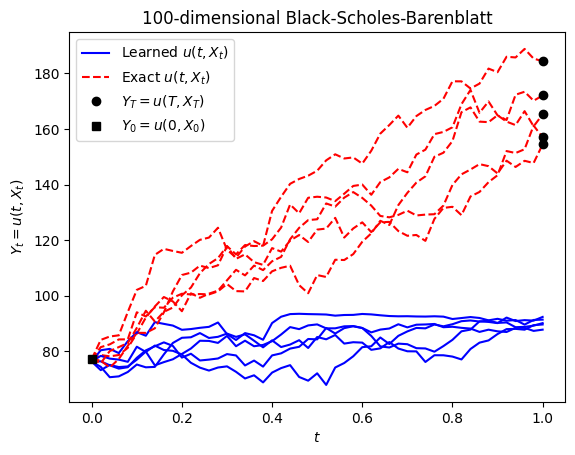

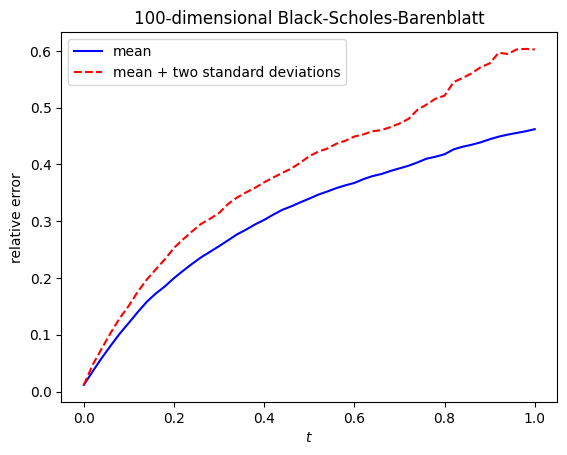

In [4]:
t_test, W_test = model.fetch_minibatch()

X_pred, Y_pred = model.predict(Xi, t_test, W_test)

def u_exact(t, X): # (N+1) x 1, (N+1) x D
    r = 0.05
    sigma_max = 0.4
    return np.exp((r + sigma_max**2)*(T - t))*np.sum(X**2, 1, keepdims = True) # (N+1) x 1

Y_test = np.reshape(u_exact(np.reshape(t_test[0:M,:,:],[-1,1]), np.reshape(X_pred[0:M,:,:],[-1,D])),[M,-1,1])

samples = 5

plt.figure()
plt.plot(t_test[0:1,:,0].numpy().T,Y_pred[0:1,:,0].T,'b',label='Learned $u(t,X_t)$')
plt.plot(t_test[0:1,:,0].numpy().T,Y_test[0:1,:,0].T,'r--',label='Exact $u(t,X_t)$')
plt.plot(t_test[0:1,-1,0],Y_test[0:1,-1,0],'ko',label='$Y_T = u(T,X_T)$')

plt.plot(t_test[1:samples,:,0].numpy().T,Y_pred[1:samples,:,0].T,'b')
plt.plot(t_test[1:samples,:,0].numpy().T,Y_test[1:samples,:,0].T,'r--')
plt.plot(t_test[1:samples,-1,0],Y_test[1:samples,-1,0],'ko')

plt.plot([0],Y_test[0,0,0],'ks',label='$Y_0 = u(0,X_0)$')

plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.title('100-dimensional Black-Scholes-Barenblatt')
plt.legend()

# savefig('./figures/BSB_Apr18_50', crop = False)


errors = np.sqrt((Y_test-Y_pred)**2/Y_test**2)
mean_errors = np.mean(errors,0)
std_errors = np.std(errors,0)

plt.figure()
plt.plot(t_test[0,:,0],mean_errors,'b',label='mean')
plt.plot(t_test[0,:,0],mean_errors+2*std_errors,'r--',label='mean + two standard deviations')
plt.xlabel('$t$')
plt.ylabel('relative error')
plt.title('100-dimensional Black-Scholes-Barenblatt')
plt.legend()

# savefig('./figures/BSB_Apr18_50_errors', crop = False)